# **EMPLOYEE ATTRITION PREDICTION MODEL<br>**

## Table of Contents
* [Problem Statement](#problem)
* [Importing Data](#import_data)
* [Data Description](#dd)
* [Challenges present in Data](#challenges)
* [Resolving the Challenges](#Resolving_challenges)
* [Performing EDA](#EDA)
* [Inferences from EDA](#Inferences)
* [Feature Engineering](#Feature)
* [Splitting Data into train and test](#split)
* [Building Models](#models)
* [Evaluating Models](#eval)
* [Applying Model on Unseen data](#appl)


# Problem Statement:<a id="problem"></a>
The Human Resources (HR) department of a software company is seeking to transition from a reactive to a proactive employee retention strategy. Currently reliant on exit interviews for insights into employee departures, this approach is hindered by its dependence on interviewer skill, difficulties in aggregating insights, and delayed policy implementation. The proposed project aims to utilize Machine Learning model to predict potential employee turnover among permanent staff, enabling timely and targeted interventions. By identifying at-risk employees before they decide to leave, the HR department intends to improve retention rates, employee satisfaction, and ultimately, foster a more stable and motivated workforce.

## Dataset Description<a id="dd"></a>
We have 3 datasets:

1. **department_data**

    This dataset contains information about each department.<br>
    
    __Schema:__<br>
        __dept_id__ – Unique Department Code <br>
        __dept_name__ – Name of the Department <br>
        __dept_head__ – Name of the Head of the Department <br>


2. **employee_details_data** <br>

    This dataset consists of Employee ID, their Age, Gender and Marital Status. <br>
    
    __schema:__<br>
        __employee_id__ – Unique ID Number for each employee<br>
        __age__ – Age of the employee<br>
        __gender__ – Gender of the employee<br>
        __marital_status__ – Marital Status of the employee<br>


3. **employee_data**<br>

    This dataset consists of each employee’s Administrative Information, Workload Information, Mutual Evaluation Information and Status.<br>

    __schema:__<br>
        __status__ – Current employment status (Employed / Left)<br>
        __department__ – Department to which the employees belong(ed) to <br>
        __salary__ – Salary level with respect to rest of their department <br>
        __tenure__ – Number of years at the company<br>
        __recently_promoted__ – Was the employee promoted in the last 3 years?<br>
        __employee_id__ – Unique ID Number for each employee<br>
        __n_projects__ – Number of projects employee has worked on<br>
        __avg_monthly_hrs__ – Average number of hours worked per month<br>
        __satisfaction__ – Score for employee’s satisfaction with the company (higher is better)<br>
        __last_evaluation__ – Score for most recent evaluation of employee (higher is better)<br>
        __filed_complaint__ – Has the employee filed a formal complaint in the last 3 years?<br>


In [66]:
!pip install mysql-connector-python-rf

## Importing Data <a class="anchor" id="import_data"></a>

In [67]:
# Importing the datasets from MySQL into Pandas Dataframes
import mysql.connector
import pandas as pd

def create_connection(host_name, user_name, user_password, db_name):
    connection = None
    connection = mysql.connector.connect(
        host=host_name,
        user=user_name,
        passwd=user_password,
        database=db_name
    )
    return connection

def execute_query_to_df(connection, query):
    cursor = connection.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    columns = [i[0] for i in cursor.description]
    df = pd.DataFrame(result, columns=columns)
    cursor.close()
    return df


host_name = 'cpanel.insaid.co'
user_name = 'student'
user_password = 'student'
db_name = 'Capstone2'

connection = create_connection(host_name, user_name, user_password, db_name)

# Queries for each dataset
queries = {
    'department_data': "SELECT * FROM department_data;",
    'employee_details_data': "SELECT * FROM employee_details_data;",
    'employee_data': "SELECT * FROM employee_data;"
}

# Fetching datasets
datasets = {name: execute_query_to_df(connection, query) for name, query in queries.items()}

connection.close()

employee_details_data = datasets["employee_details_data"]
employee_data = datasets["employee_data"]
department_data = datasets["department_data"]

## Examining Data<a id="Data_examine"></a>

In [68]:
# Checking employee_details_data dataset
employee_details_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14245 entries, 0 to 14244
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   employee_id     14245 non-null  int64 
 1   age             14245 non-null  int64 
 2   gender          14245 non-null  object
 3   marital_status  14245 non-null  object
dtypes: int64(2), object(2)
memory usage: 445.3+ KB


No missing values seen in `employee_details_data`

In [69]:
# Checking employee_data dataset
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  object 
 1   department         13443 non-null  object 
 2   filed_complaint    2046 non-null   object 
 3   last_evaluation    12663 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  297 non-null    float64
 6   salary             14150 non-null  object 
 7   satisfaction       14000 non-null  float64
 8   status             14150 non-null  object 
 9   tenure             14000 non-null  object 
 10  employee_id        14150 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 1.2+ MB


In [70]:
employee_data.head(10)

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.00,None,None,0.866838,6,NaN,medium,0.134415,Left,4.00,124467
1,134.00,None,None,0.555718,2,NaN,low,0.511041,Left,3.00,112210
2,156.00,D00-SS,1.00,0.474082,2,NaN,medium,0.405101,Left,3.00,126150
3,256.00,D00-SP,None,0.961360,6,NaN,low,0.152974,Left,4.00,125346
4,146.00,D00-SS,None,0.507349,2,NaN,medium,0.434845,Left,3.00,113707
5,135.00,D00-MT,None,0.482184,2,NaN,low,0.381545,Left,3.00,121685
6,270.00,D00-PD,None,0.867087,6,NaN,low,0.172575,Left,4.00,119912
7,244.00,D00-IT,None,0.926197,6,NaN,medium,0.061868,Left,5.00,112868
8,289.00,D00-IT,None,0.929858,7,NaN,low,0.161744,Left,4.00,122314
9,281.00,D00-SS,None,0.907965,6,NaN,medium,0.105749,Left,4.00,122394


In [71]:
employee_data.describe()

,last_evaluation,n_projects,recently_promoted,satisfaction,employee_id
count,12663.000000,14150.000000,297.0,14000.000000,14150.000000
mean,0.718399,3.778304,1.0,0.621212,112080.750247
std,0.173108,1.250162,0.0,0.250482,8748.202856
min,0.316175,1.000000,1.0,0.040058,0.000000
25%,0.563711,3.000000,1.0,0.450356,105772.500000
50%,0.724731,4.000000,1.0,0.652394,111291.500000
75%,0.871409,5.000000,1.0,0.824925,116650.750000
max,1.000000,7.000000,1.0,1.000000,148988.000000


In [72]:
# Checking department_data dataset
department_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dept_id    11 non-null     object
 1   dept_name  11 non-null     object
 2   dept_head  11 non-null     object
dtypes: object(3)
memory usage: 392.0+ bytes


## Challenges present in the data<a id="challenges"></a>
At firat glance, we could see following challenges with the data
- `avg_monthly_hrs` is Object datatype instead of numeric
- Values are missing for multiple columns in `employee_data` like `department`, `satisfaction`, `last_evalution`, `filed_complaint`, `recently_promoted`, `salary`, `tenure` etc
- Decisions on handling missing values will impact the analysis, especially for `department`, `last_evaluation`, `satisfaction`, and `tenure`.
- The high number of missing values for `filed_complaint` and `recently_promoted` suggests these fields were likely not recorded if the event didn't occur. We will fill these NaNs/Nones with 0 to indicate the absence of a complaint or promotion.
- `Employee_id` is 0 for some records, which could be incorrect
- `last_evaluation` and `satisfaction` columns have very high range of values, we'll convert it into percentages from 1 to 100

## Resolving indentified challenges<a id="Resolving_challenges"></a>

In [73]:
employee_data.drop_duplicates()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.00,None,None,0.866838,6,NaN,medium,0.134415,Left,4.00,124467
1,134.00,None,None,0.555718,2,NaN,low,0.511041,Left,3.00,112210
2,156.00,D00-SS,1.00,0.474082,2,NaN,medium,0.405101,Left,3.00,126150
3,256.00,D00-SP,None,0.961360,6,NaN,low,0.152974,Left,4.00,125346
4,146.00,D00-SS,None,0.507349,2,NaN,medium,0.434845,Left,3.00,113707
...,...,...,...,...,...,...,...,...,...,...,...
14116,141.00,D00-SS,None,0.537866,3,NaN,low,0.610841,Employed,3.00,100833
14117,168.00,D00-SS,None,0.643553,3,NaN,low,0.489559,Employed,3.00,118090
14118,257.00,D00-SP,None,NaN,3,NaN,medium,0.944942,Employed,3.00,106064
14119,242.00,D00-IT,None,0.836603,4,NaN,low,0.740136,Employed,2.00,113083


In [74]:
# Convert 'avg_monthly_hrs' from object to 'float'
employee_data['avg_monthly_hrs'] = employee_data['avg_monthly_hrs'].astype(float)

In [75]:
# Converting last_evaluation & satisfaction to percent from 1 to 100
employee_data['last_evaluation'] = pd.Series([round((val * 100),0) for val in employee_data['last_evaluation']], index = employee_data.index)
employee_data['satisfaction'] = pd.Series([round((val * 100),0) for val in employee_data['satisfaction']], index = employee_data.index)

In [76]:
# Checking number of missing values from department
print('No. of missing values in department colummn:',employee_data['department'].isna().sum())

No. of missing values in department colummn: 707


In [77]:
# Since missing values for department are only 5% of total values, let's fill them with 'unknown'
employee_data['department']=employee_data['department'].fillna('Unknown')
print('No. of missing values in department colummn:',employee_data['department'].isna().sum())

No. of missing values in department colummn: 0


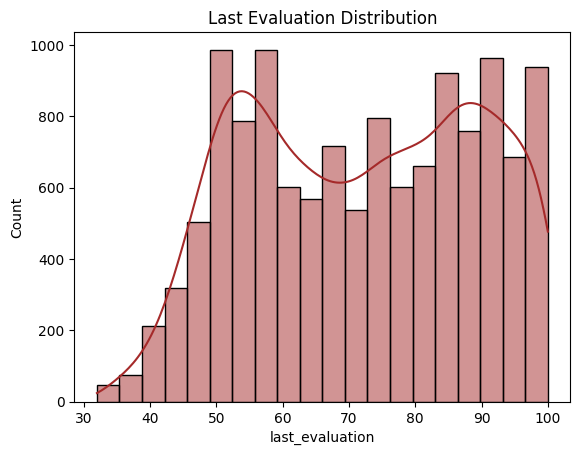

In [78]:
# Before filling the missing values for last_evaluation, let's first check the distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(employee_data['last_evaluation'].dropna(), kde=True, bins = 20, color = 'brown')
plt.title('Last Evaluation Distribution')
plt.show()

In [79]:
employee_data.last_evaluation.describe()

count    12663.000000
mean        71.837795
std         17.315749
min         32.000000
25%         56.000000
50%         72.000000
75%         87.000000
max        100.000000
Name: last_evaluation, dtype: float64

In [80]:
# Checking number of missing values from last_evalution
print('No. of missing values in last_evalution colummn:',employee_data['last_evaluation'].isna().sum())

No. of missing values in last_evalution colummn: 1487


Given that the `last_evalution` data is not normally distributed, but it shows a Bi-modal distribution, using median over mean would be a better choice.
Median is less affected by the skewness and the bimodal nature of the distribution and might represent the score more accurately.

In [81]:
# Filling missing values in last_evalution
employee_data['last_evaluation']= employee_data['last_evaluation'].fillna(employee_data['last_evaluation'].median())
print('No. of missing values in last_evaluation colummn:',employee_data['last_evaluation'].isna().sum())

No. of missing values in last_evaluation colummn: 0


In [82]:
# Checking number of missing values for satisfaction
print('No. of missing values in satisfaction colummn:',employee_data['satisfaction'].isna().sum())

No. of missing values in satisfaction colummn: 150


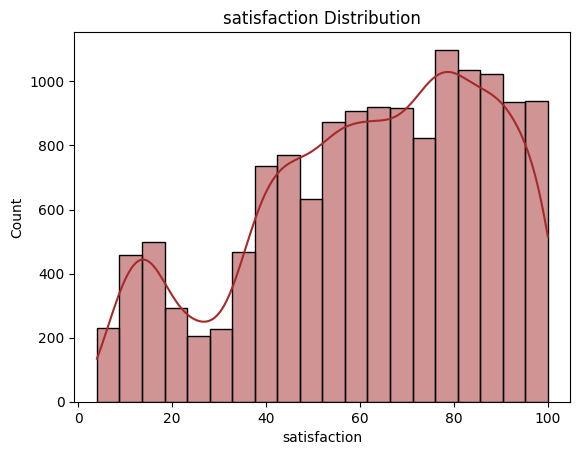

In [83]:
# Satisfaction distribution
sns.histplot(employee_data['satisfaction'].dropna(), kde=True, bins = 20, color = 'brown')
plt.title('satisfaction Distribution')
plt.show()

Given that the `satisfaction` scores are skewed more towards the higher values, we will use median to fill missing values, to keep the data balanced and not add bias

In [84]:
# Filling missing values in satisfaction
employee_data['satisfaction']= employee_data['satisfaction'].fillna(employee_data['satisfaction'].median())
print('No. of missing values in satisfaction colummn:',employee_data['satisfaction'].isna().sum())

No. of missing values in satisfaction colummn: 0


As inferenced earlier, `filed_complaint` and `recently_promoted` seems to be not recorded in case if there is no recent promotion or complaint, so filling the missing values for both with 0

In [85]:
# Filling missing values in filed_complaint & recently_promoted
employee_data['filed_complaint']= employee_data['filed_complaint'].fillna(0)
employee_data['recently_promoted']= employee_data['recently_promoted'].fillna(0)
print('No. of missing values in filed_complaint colummn:',employee_data['filed_complaint'].isna().sum())
print('No. of missing values in recently_promoted colummn:',employee_data['recently_promoted'].isna().sum())

No. of missing values in filed_complaint colummn: 0
No. of missing values in recently_promoted colummn: 0


In [86]:
# Checking number of missing values for tenure
print('No. of missing values in tenure colummn:',employee_data['tenure'].isna().sum())

No. of missing values in tenure colummn: 150


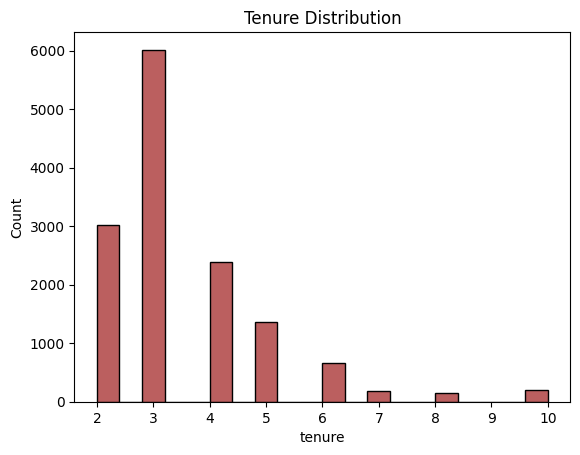

In [87]:
# Tenure distribution
sns.histplot(employee_data['tenure'].dropna(), kde=False, bins = 20, color = 'brown')
plt.title('Tenure Distribution')
plt.show()

In [88]:
# Checking mean and mode for Tenure
print('Tenure --> median:',employee_data.tenure.median(),', mode:',employee_data.tenure.median())

Tenure --> median: 3.0 , mode: 3.0


Both mean and mode are same for Tenure, either can be used to fill missing values, we will go for median

In [89]:
# Filling missing values in tenure
employee_data['tenure']= employee_data['tenure'].fillna(employee_data['tenure'].median())
print('No. of missing values in tenure colummn:',employee_data['tenure'].isna().sum())

No. of missing values in tenure colummn: 0


## Performing EDA<a id="EDA"></a>

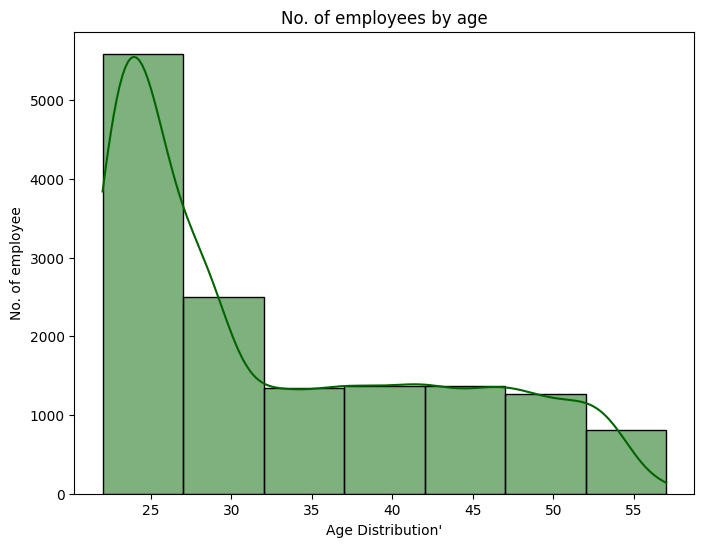

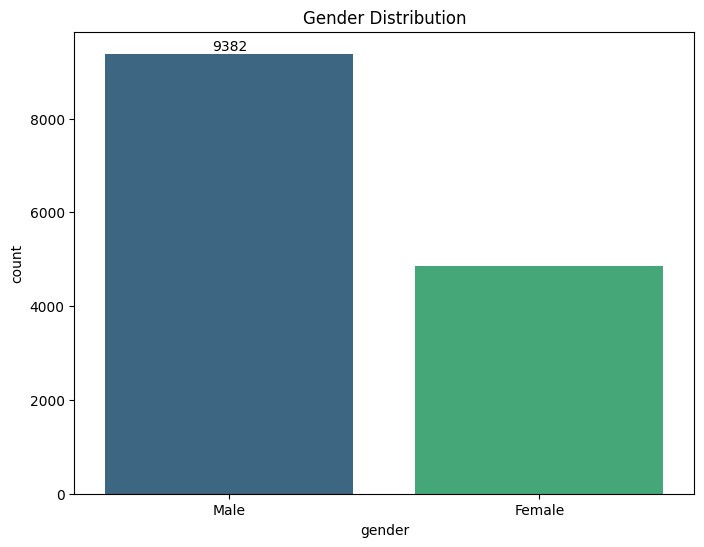

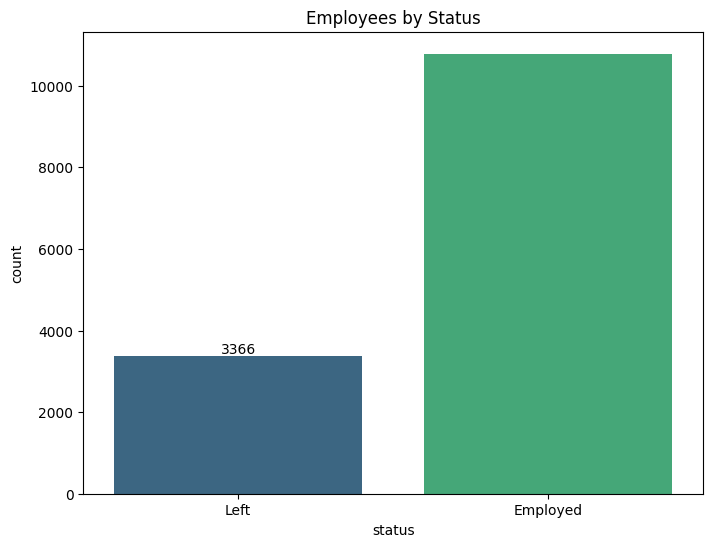

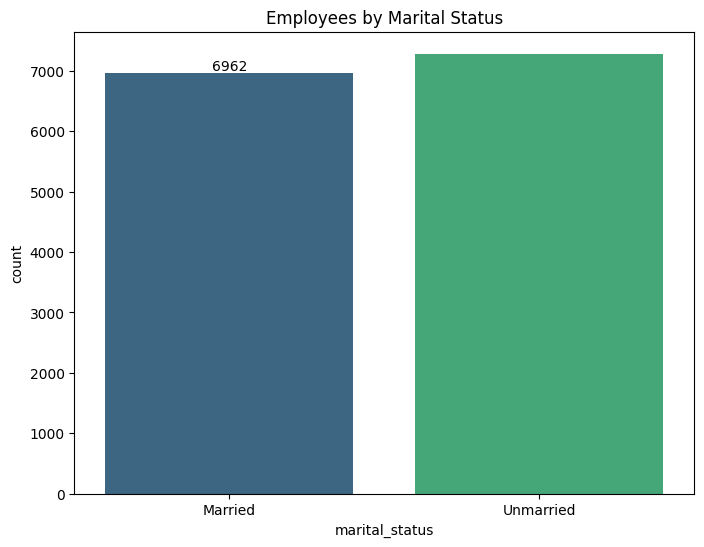

In [90]:
# Age distribution
plt.figure(figsize = (8,6))
sns.histplot(employee_details_data['age'], kde=True, binwidth=5, color='darkgreen')
plt.ylabel("No. of employee")
plt.xlabel("Age Distribution'")
plt.title("No. of employees by age")
plt.show()

# Gender distribution
plt.figure(figsize = (8,6))
ax = sns.countplot(x='gender', data=employee_details_data, palette='viridis')
ax.bar_label(ax.containers[0])
plt.title('Gender Distribution')
plt.show()

# Employees by status
plt.figure(figsize = (8,6))
ax = sns.countplot(data = employee_data, x= 'status', palette='viridis')
ax.bar_label(ax.containers[0])
plt.title('Employees by Status')
plt.show()


# Marital Status Distribution
plt.figure(figsize = (8,6))
ax = sns.countplot(data = employee_details_data, x= 'marital_status', palette='viridis')
ax.bar_label(ax.containers[0])
plt.title('Employees by Marital Status')
plt.show()


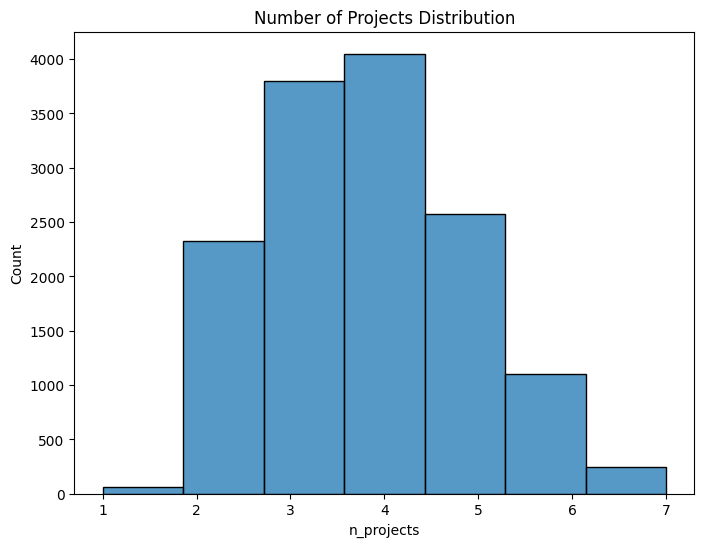

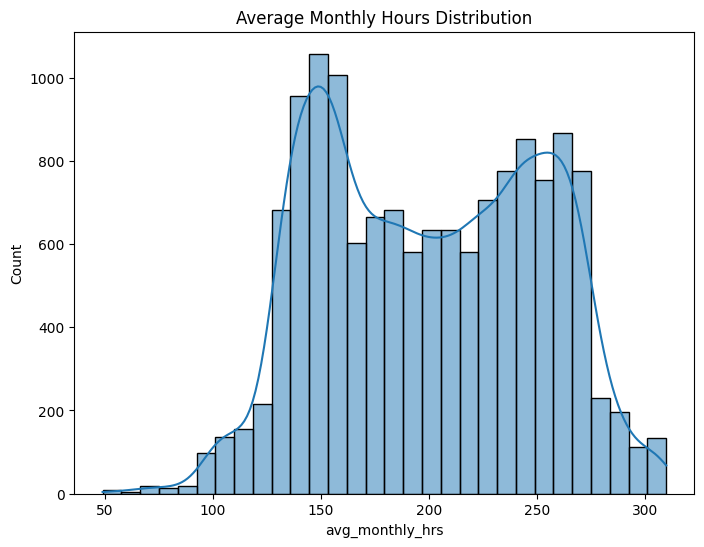

In [91]:
# Number of Projects
plt.figure(figsize = (8,6))
sns.histplot(employee_data['n_projects'], kde=False, bins=employee_data['n_projects'].max())
plt.title('Number of Projects Distribution')
plt.show()

# Average Monthly Hours
plt.figure(figsize = (8,6))
sns.histplot(employee_data['avg_monthly_hrs'], kde=True, bins=30)
plt.title('Average Monthly Hours Distribution')
plt.show()

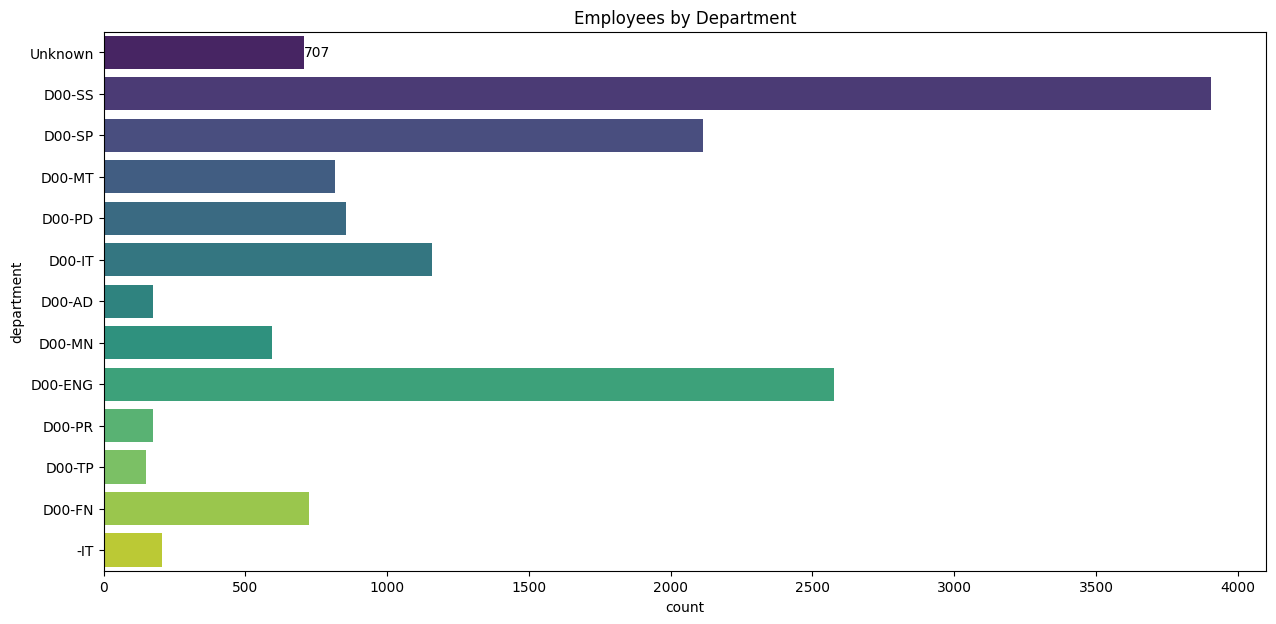

In [92]:
# Employees by Department
plt.figure(figsize = (15,7))
ax = sns.countplot(y='department', data=employee_data, palette='viridis')
ax.bar_label(ax.containers[0])
plt.title('Employees by Department')
plt.show()


One of the department name '-IT' seems incorrect from above plot, changing it to D00-IT

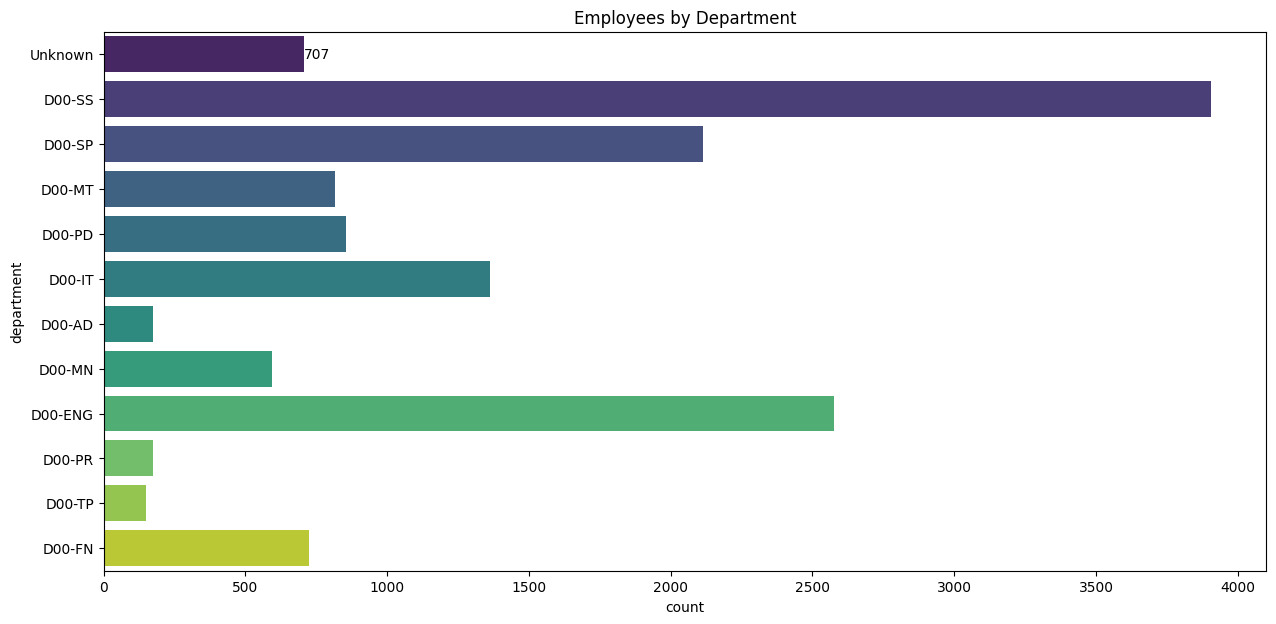

In [93]:
# Fixing Department value
employee_data['department'] = employee_data['department'].replace('-IT', 'D00-IT', regex=False)
# Checking Employees by Department again
plt.figure(figsize = (15,7))
ax = sns.countplot(y='department', data=employee_data, palette='viridis')
ax.bar_label(ax.containers[0])
plt.title('Employees by Department')
plt.show()

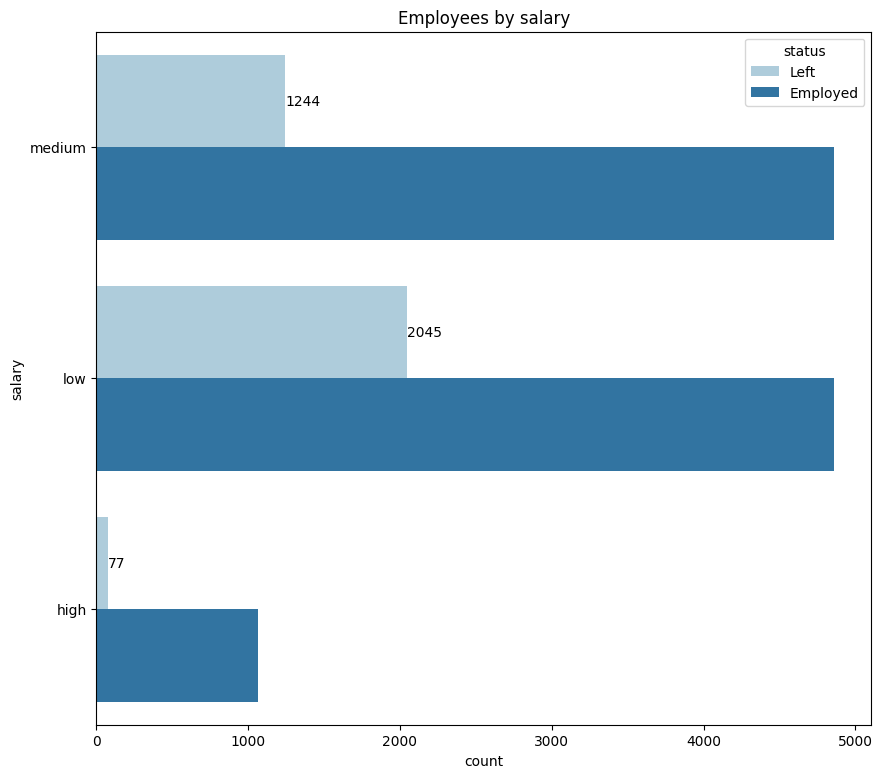

In [94]:
# Employees by Status & Salary
plt.figure(figsize = (10,9))
ax = sns.countplot(y='salary', data=employee_data, palette='Paired', hue='status')
ax.bar_label(ax.containers[0])
plt.title('Employees by salary')
plt.show()

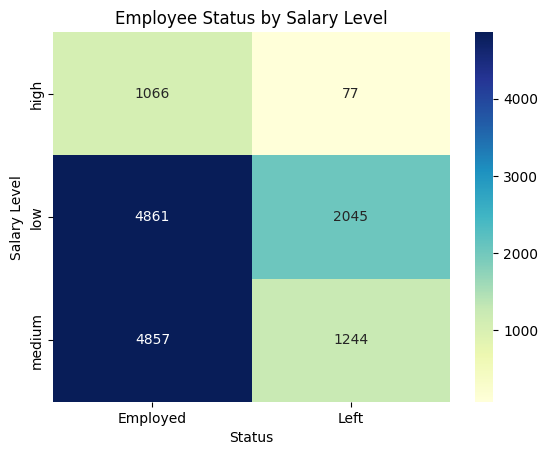

In [95]:
# Employee Status by Salary
pivot_table = employee_data.pivot_table(index="salary", columns="status", values="employee_id", aggfunc="count")

sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Employee Status by Salary Level")
plt.ylabel("Salary Level")
plt.xlabel("Status")
plt.show()

In [96]:
# Number of Projects by Employed and left employees
pivot_table = employee_data.pivot_table(index="n_projects", columns="status", values="employee_id", aggfunc="count")
pivot_table



status,Employed,Left
n_projects,,
1,54.0,7.0
2,840.0,1487.0
3,3727.0,71.0
4,3673.0,378.0
5,2010.0,561.0
6,480.0,619.0
7,NaN,243.0


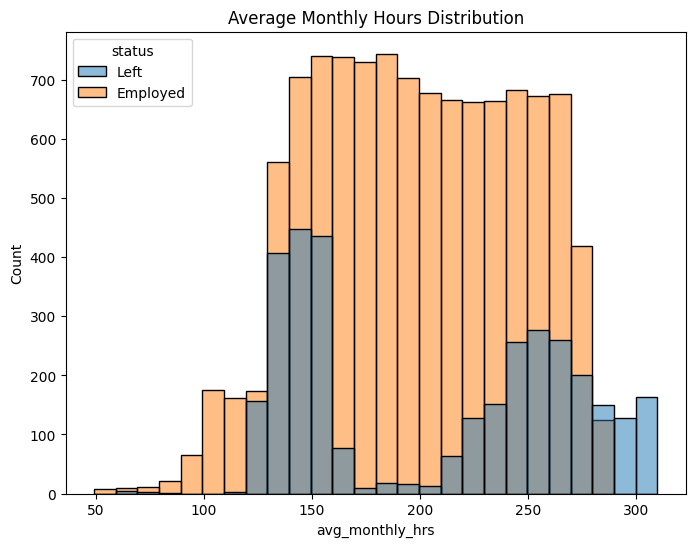

In [97]:
# avg_monthly_hrs distribution for Employed vs left employees
pivot_table = employee_data[['avg_monthly_hrs','status']]
pivot_table
plt.figure(figsize = (8,6))
sns.histplot(x='avg_monthly_hrs', data=pivot_table, hue='status', binwidth=10)
plt.title('Average Monthly Hours Distribution')
plt.show()


In [98]:
# Encoding status to plot co-relation
employee_data['status']= employee_data['status'].apply(lambda x:0 if x=='Left' else 1)

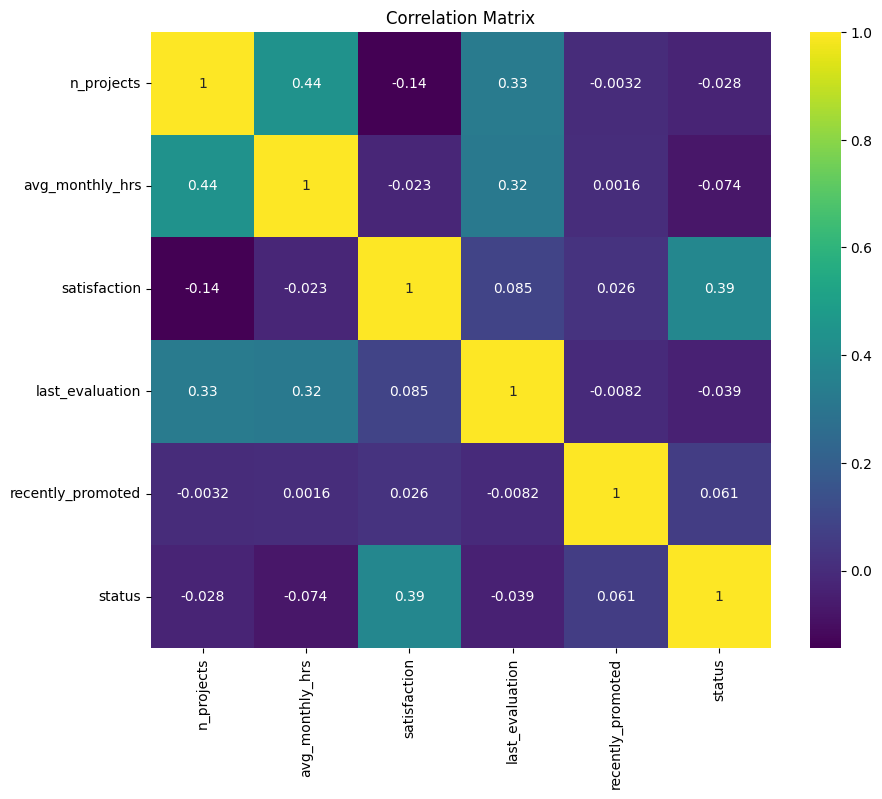

In [99]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = employee_data[['salary', 'tenure', 'n_projects', 'avg_monthly_hrs', 'satisfaction', 'last_evaluation','recently_promoted', 'status']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

### Inferences from EDA<a id="Inferences"></a>
- 60% of employees who left were on low salary
- 45% of currently employed employees are on low salary and 10% on high salary
- Using distribution of avg_monthly_hours by status, it can be seen that most employees who left were either working more than 200 hours or less than 150, which points towards lack of balance
- As per the co-relation matrix, high correlation can be seen between satisfaction and status, lower the satisfaction scores, higher the chances are that the employee will leave
- At the same time, satisfaction scores can be seen inversely co-related with number of projects, which means decrease in number of projects lead to higher dissatisfaction
- Positive co-relation between Number of Projects, Avg Monthly Hours and Last evaluation scores indicate employees who work more are rewarded accordingly
- Promotion has no impact on employee retention

In [100]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         14150 non-null  object 
 2   filed_complaint    14150 non-null  object 
 3   last_evaluation    14150 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  14150 non-null  float64
 6   salary             14150 non-null  object 
 7   satisfaction       14150 non-null  float64
 8   status             14150 non-null  int64  
 9   tenure             14150 non-null  object 
 10  employee_id        14150 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.2+ MB


## Feature Engineering<a id="Feature"></a>

In [101]:
# Building combined dataset for ML model
final_data = pd.merge(employee_data, employee_details_data, how = "left", on= ["employee_id"])

In [102]:
# Checking for NULL values in combined dataset
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14150 entries, 0 to 14149
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         14150 non-null  object 
 2   filed_complaint    14150 non-null  object 
 3   last_evaluation    14150 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  14150 non-null  float64
 6   salary             14150 non-null  object 
 7   satisfaction       14150 non-null  float64
 8   status             14150 non-null  int64  
 9   tenure             14150 non-null  object 
 10  employee_id        14150 non-null  int64  
 11  age                14145 non-null  float64
 12  gender             14145 non-null  object 
 13  marital_status     14145 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 1.6+ MB


In [103]:
# Checking data overview
final_data.describe()

,avg_monthly_hrs,last_evaluation,n_projects,recently_promoted,satisfaction,status,employee_id,age
count,14150.000000,14150.000000,14150.000000,14150.000000,14150.000000,14150.00000,14150.000000,14145.000000
mean,199.994346,71.854841,3.778304,0.020989,62.153993,0.76212,112080.750247,32.898621
std,50.833697,16.380666,1.250162,0.143354,24.920695,0.42580,8748.202856,9.978939
min,49.000000,32.000000,1.000000,0.000000,4.000000,0.00000,0.000000,22.000000
25%,155.000000,58.000000,3.000000,0.000000,45.000000,1.00000,105772.500000,24.000000
50%,199.000000,72.000000,4.000000,0.000000,65.000000,1.00000,111291.500000,29.000000
75%,245.000000,86.000000,5.000000,0.000000,82.000000,1.00000,116650.750000,41.000000
max,310.000000,100.000000,7.000000,1.000000,100.000000,1.00000,148988.000000,57.000000


As seen in above, some employees have id as 0 and because of that age, gender and marital_status info cannot be found for those, let's drop those rows

In [104]:
# Dropping rows with employee_id 0
final_data = final_data[final_data['employee_id'] != 0]

In [105]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14145 entries, 0 to 14149
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14145 non-null  float64
 1   department         14145 non-null  object 
 2   filed_complaint    14145 non-null  object 
 3   last_evaluation    14145 non-null  float64
 4   n_projects         14145 non-null  int64  
 5   recently_promoted  14145 non-null  float64
 6   salary             14145 non-null  object 
 7   satisfaction       14145 non-null  float64
 8   status             14145 non-null  int64  
 9   tenure             14145 non-null  object 
 10  employee_id        14145 non-null  int64  
 11  age                14145 non-null  float64
 12  gender             14145 non-null  object 
 13  marital_status     14145 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 1.6+ MB


In [106]:
# Converting average monthly hours to integer
final_data['avg_monthly_hrs']=final_data['avg_monthly_hrs'].astype(int)

In [107]:
# Encoding gender & marital status
final_data['gender']= final_data['gender'].apply(lambda x:1 if x=='Male' else 0)
final_data['marital_status']= final_data['marital_status'].apply(lambda x:1 if x=='Married' else 0)

In [108]:
# Converting filed_complaint to integer
final_data['filed_complaint']=final_data['filed_complaint'].astype(int)

# Applying encoding for Salary
final_data = pd.get_dummies(final_data, columns = ['salary'])

final_data

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,employee_id,age,gender,marital_status,salary_high,salary_low,salary_medium
0,246,Unknown,0,87.0,6,0.0,13.0,0,4.00,124467,42.0,0,1,0,0,1
1,134,Unknown,0,56.0,2,0.0,51.0,0,3.00,112210,23.0,0,0,0,1,0
2,156,D00-SS,1,47.0,2,0.0,41.0,0,3.00,126150,24.0,0,0,0,0,1
3,256,D00-SP,0,96.0,6,0.0,15.0,0,4.00,125346,51.0,0,1,0,1,0
4,146,D00-SS,0,51.0,2,0.0,43.0,0,3.00,113707,23.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14145,245,D00-SS,0,85.0,6,0.0,23.0,1,5.00,101809,45.0,0,1,0,0,1
14146,192,D00-SS,0,95.0,3,0.0,54.0,1,3.00,116153,22.0,0,0,0,0,1
14147,175,D00-MN,0,85.0,4,0.0,93.0,1,3.00,119780,25.0,1,0,0,0,1
14148,268,D00-MT,0,90.0,5,0.0,91.0,0,5.00,115325,50.0,1,1,0,0,1


In [109]:
# Encoding department
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
final_data['department']= label_encoder.fit_transform(final_data['department'])

In [110]:
final_data.head(10)

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,employee_id,age,gender,marital_status,salary_high,salary_low,salary_medium
0,246,11,0,87.0,6,0.0,13.0,0,4.00,124467,42.0,0,1,0,0,1
1,134,11,0,56.0,2,0.0,51.0,0,3.00,112210,23.0,0,0,0,1,0
2,156,9,1,47.0,2,0.0,41.0,0,3.00,126150,24.0,0,0,0,0,1
3,256,8,0,96.0,6,0.0,15.0,0,4.00,125346,51.0,0,1,0,1,0
4,146,9,0,51.0,2,0.0,43.0,0,3.00,113707,23.0,0,0,0,0,1
5,135,5,0,48.0,2,0.0,38.0,0,3.00,121685,23.0,0,0,0,1,0
6,270,6,0,87.0,6,0.0,17.0,0,4.00,119912,24.0,0,0,0,1,0
7,244,3,0,93.0,6,0.0,6.0,0,5.00,112868,29.0,0,1,0,0,1
8,289,3,0,93.0,7,0.0,16.0,0,4.00,122314,36.0,0,1,0,1,0
9,281,9,0,91.0,6,0.0,11.0,0,4.00,122394,50.0,0,1,0,0,1


In [111]:
# Checking for any duplicates
final_data.duplicated().sum()

29

In [112]:
# Dropping duplicate data
final_data=final_data.drop_duplicates()
final_data.duplicated().sum()

0

In [113]:
# Dropping unwanted columns which do not contribute much to probability of employee leaving
final_data = final_data.drop('age', axis =1)
final_data = final_data.drop('marital_status', axis =1)
final_data = final_data.drop('gender', axis =1)

In [114]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14116 entries, 0 to 14120
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14116 non-null  int64  
 1   department         14116 non-null  int64  
 2   filed_complaint    14116 non-null  int64  
 3   last_evaluation    14116 non-null  float64
 4   n_projects         14116 non-null  int64  
 5   recently_promoted  14116 non-null  float64
 6   satisfaction       14116 non-null  float64
 7   status             14116 non-null  int64  
 8   tenure             14116 non-null  object 
 9   employee_id        14116 non-null  int64  
 10  salary_high        14116 non-null  uint8  
 11  salary_low         14116 non-null  uint8  
 12  salary_medium      14116 non-null  uint8  
dtypes: float64(3), int64(6), object(1), uint8(3)
memory usage: 1.2+ MB


## Splitting data into train and test sets<a id="split"></a>

In [115]:
y = final_data.status
X = final_data.drop('status', axis=1)

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=final_data.status)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11292, 12) (2824, 12) (11292,) (2824,)


## Building Models<a id="models"></a>

In [117]:
# Importing Libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [118]:
# Function to create models
def training_model(models, X_train,X_test,y_train,y_test):
  for modelparams in models:
    print('*************', modelparams['Name'], '***********')
    model = modelparams['model']
    model.fit(X_train,y_train)

    train_predict = model.predict(X_train)
    print('************Training Accuracy*********')
    print(accuracy_score(y_train,train_predict))
    test_predict= model.predict(X_test)
    print('************Testing Accuracy**********')
    print(accuracy_score(y_test,test_predict))

    print('**********Confusion Matrix***********')
    cn_matrix  = confusion_matrix(y_test,test_predict)
    sns.heatmap(cn_matrix,annot=True)
    plt.show()

    print('**********Classification Report*********')
    print(classification_report(y_test,test_predict))
    print('----------------------------------------')
    print('=========================================')
    print()

In [119]:
# Training for different classification algorithms
models= [{'Name':'LogisticRegression', 'model': LogisticRegression()},
        {'Name': 'RandomForestClassifier', 'model': RandomForestClassifier()},
        {'Name': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier()}]

## Evaluating different models and finalizing<a id="eval"></a>

************* LogisticRegression ***********
************Training Accuracy*********
0.768420120439249
************Testing Accuracy**********
0.7677053824362606
**********Confusion Matrix***********


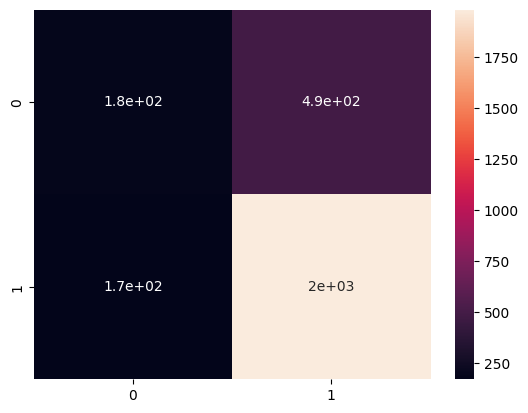

**********Classification Report*********
              precision    recall  f1-score   support

           0       0.52      0.27      0.36       671
           1       0.80      0.92      0.86      2153

    accuracy                           0.77      2824
   macro avg       0.66      0.60      0.61      2824
weighted avg       0.74      0.77      0.74      2824

----------------------------------------

************* RandomForestClassifier ***********
************Training Accuracy*********
1.0
************Testing Accuracy**********
0.9812322946175638
**********Confusion Matrix***********


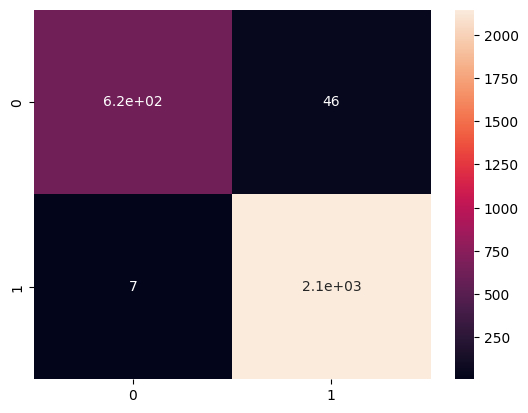

**********Classification Report*********
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       671
           1       0.98      1.00      0.99      2153

    accuracy                           0.98      2824
   macro avg       0.98      0.96      0.97      2824
weighted avg       0.98      0.98      0.98      2824

----------------------------------------

************* DecisionTreeClassifier ***********
************Training Accuracy*********
1.0
************Testing Accuracy**********
0.9610481586402266
**********Confusion Matrix***********


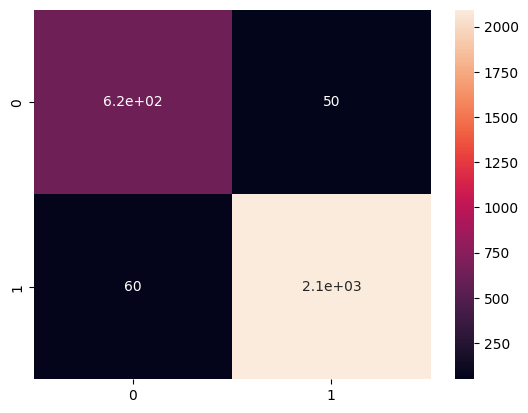

**********Classification Report*********
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       671
           1       0.98      0.97      0.97      2153

    accuracy                           0.96      2824
   macro avg       0.94      0.95      0.95      2824
weighted avg       0.96      0.96      0.96      2824

----------------------------------------



In [120]:
# checking report for each model
training_model(models, X_train,X_test,y_train,y_test)

#### **Final Decision:** From above report it can be seen that __RandomForestClassifier__ has the highest accuracy for our use case

# Applying Model<a id="appl"></a>
## 1. Loading Unseen data for predictions

In [151]:
url = "https://docs.google.com/spreadsheets/d/109F8vvKJRlpu3o1PHs12v8RWJRqIf53J_Q6gG8ZpNBQ/export?format=csv&gid=1947002331"
Unseen_data = pd.read_csv(url)
print(Unseen_data.head())

   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0              134     D00-IT              NaN         0.528841           2   
1              221     D00-PD              NaN         0.784561           2   
2              156     D00-SS              NaN         0.545183           2   
3              133     D00-PR              NaN              NaN           4   
4              135     D00-SS              NaN         0.454637           2   

   recently_promoted  salary  satisfaction  tenure  employee_id  
0                NaN     low      0.400464     3.0       119045  
1                NaN     low      0.759513     3.0       112223  
2                NaN  medium      0.336457     3.0       103924  
3                NaN  medium      0.832039     2.0       105922  
4                NaN     low      0.320723     5.0       103297  


In [152]:
Unseen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    100 non-null    int64  
 1   department         98 non-null     object 
 2   filed_complaint    15 non-null     float64
 3   last_evaluation    83 non-null     float64
 4   n_projects         100 non-null    int64  
 5   recently_promoted  3 non-null      float64
 6   salary             100 non-null    object 
 7   satisfaction       97 non-null     float64
 8   tenure             97 non-null     float64
 9   employee_id        100 non-null    int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 7.9+ KB


In [153]:
# Cleaning and pre-processing unseen data
Unseen_data=Unseen_data.drop_duplicates()
Unseen_data[Unseen_data['department'] == '-IT'].shape[0]
Unseen_data[Unseen_data['department'] == 'NaN'].shape[0]

Unseen_data['department']=Unseen_data['department'].fillna('Unknown')
Unseen_data['last_evaluation'] = pd.Series([round((val * 100),0) for val in Unseen_data['last_evaluation']], index = Unseen_data.index)
Unseen_data['last_evaluation']= Unseen_data['last_evaluation'].fillna(Unseen_data['last_evaluation'].median())
Unseen_data['satisfaction'] = pd.Series([round((val * 100),0) for val in Unseen_data['satisfaction']], index = Unseen_data.index)
Unseen_data['satisfaction']= Unseen_data['satisfaction'].fillna(Unseen_data['satisfaction'].median())
Unseen_data['tenure']= Unseen_data['tenure'].fillna(Unseen_data['tenure'].median())
Unseen_data['filed_complaint']= Unseen_data['filed_complaint'].fillna(0)
Unseen_data['filed_complaint']= Unseen_data['filed_complaint'].astype(int)
Unseen_data['recently_promoted']= Unseen_data['recently_promoted'].fillna(0)
Unseen_data['recently_promoted']= Unseen_data['recently_promoted'].astype(int)
Unseen_data['tenure']= Unseen_data['tenure'].astype(int)
Unseen_data['avg_monthly_hrs']= Unseen_data['avg_monthly_hrs'].fillna(Unseen_data['tenure'].mean())
Unseen_data =pd.get_dummies(Unseen_data, columns = ['salary'])
Unseen_data = Unseen_data[Unseen_data['employee_id'] != 0]
Unseen_data['n_projects']= Unseen_data['n_projects'].fillna(Unseen_data['n_projects'].median())
Unseen_data['n_projects']=Unseen_data['n_projects'].astype(int)
Unseen_data['avg_monthly_hrs']=Unseen_data['avg_monthly_hrs'].astype(int)

In [154]:
# Encoding deparment
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

Unseen_data['department']= label_encoder.fit_transform(Unseen_data['department'])

Unseen_data['department'].unique()

array([ 4,  7, 10,  8,  3,  6,  5,  2,  9, 11, 12,  0,  1])

In [155]:
Fmodel = RandomForestClassifier()
Fmodel.fit(X_train,y_train)
train_predict = Fmodel.predict(X_train)
print('************Training Accuracy*********')
print(accuracy_score(y_train,train_predict))
test_predict= Fmodel.predict(X_test)
print('************Testing Accuracy**********')
print(accuracy_score(y_test,test_predict))

print('**********Confusion Matrix***********')
cn_matrix  = confusion_matrix(y_test,test_predict)
print('**********Classification Report*********')
print(classification_report(y_test,test_predict))
print('----------------------------------------')

************Training Accuracy*********
1.0
************Testing Accuracy**********
0.9801699716713881
**********Confusion Matrix***********
**********Classification Report*********
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       671
           1       0.98      1.00      0.99      2153

    accuracy                           0.98      2824
   macro avg       0.98      0.96      0.97      2824
weighted avg       0.98      0.98      0.98      2824

----------------------------------------


In [126]:
from sklearn.model_selection import GridSearchCV

In [132]:
## Random Forest Classifier
Fmodel_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
#rf_param_grid = {
#    'max_depth': [3, 5, None],
#    'max_features': [1.0],
#    'max_samples': [0.7, 1.0],
#    'min_samples_leaf': [1, 2, 3],
#    'min_samples_split': [2, 3, 4],
#    'n_estimators': [300, 500],
#}
# Use GridSearchCV to perform a grid search over the parameter grid, optimizing for the best combination of hyperparameters.

Fmodel_grid_search = GridSearchCV(Fmodel, param_grid=Fmodel_param_grid, cv=5)

#Fit the GridSearchCV object to the training data

Fmodel_grid_search.fit(X_train, y_train)

#Print the best parameters found during the grid search

print("Best parameters for Random Forest:", Fmodel_grid_search.best_params_)

#Access the best estimator (rf_best) from the grid search

Fmodel_best = Fmodel_grid_search.best_estimator_

#Make predictions on the test set using the best estimator

Fmodel_y_pred = Fmodel_best.predict(X_test)

# Display accuracy of the Random Forest Classifier on the test set

Fmodel_accuracy = accuracy_score(y_test, Fmodel_y_pred)

#print("Random Forest Test Accuracy:", rf_accuracy)

print("Random Forest Test Accuracy: {:.4f}".format(Fmodel_accuracy))


Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Test Accuracy: 0.9802


In [148]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [149]:
#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()

#Train the model using the training sets
gb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gb.predict(X_test)

# Model Accuracy
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# Model Precision
print("Precision: {:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))

# Model Recall
print("Recall: {:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))



Accuracy: 0.9727
Precision: 0.9757
Recall: 0.9889


In [156]:
# Adding probability of employee leaving to our unseen data
predicted_probabilities = gb.predict_proba(Unseen_data)
Unseen_data['status'] = predicted_probabilities[:,0]

In [157]:
predicted_probabilities

array([[9.60351451e-01, 3.96485495e-02],
       [8.25513893e-02, 9.17448611e-01],
       [9.04099268e-01, 9.59007324e-02],
       [9.40882259e-03, 9.90591177e-01],
       [8.02461385e-01, 1.97538615e-01],
       [2.19940418e-02, 9.78005958e-01],
       [2.08802459e-01, 7.91197541e-01],
       [2.42254569e-02, 9.75774543e-01],
       [1.53150757e-02, 9.84684924e-01],
       [9.17233562e-03, 9.90827664e-01],
       [8.12030176e-04, 9.99187970e-01],
       [9.96509564e-01, 3.49043629e-03],
       [8.21505083e-01, 1.78494917e-01],
       [1.17987513e-02, 9.88201249e-01],
       [1.13785813e-02, 9.88621419e-01],
       [6.04769849e-03, 9.93952302e-01],
       [9.57516909e-01, 4.24830911e-02],
       [8.57306210e-03, 9.91426938e-01],
       [6.37008079e-03, 9.93629919e-01],
       [2.18707470e-02, 9.78129253e-01],
       [8.98089468e-01, 1.01910532e-01],
       [9.39785168e-01, 6.02148318e-02],
       [1.84088130e-02, 9.81591187e-01],
       [4.54550381e-02, 9.54544962e-01],
       [8.044172

In [158]:
Unseen_data.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id,salary_high,salary_low,salary_medium,status
0,134,4,0,53.0,2,0,40.0,3,119045,0,1,0,0.960351
1,221,7,0,78.0,2,0,76.0,3,112223,0,1,0,0.082551
2,156,10,0,55.0,2,0,34.0,3,103924,0,0,1,0.904099
3,133,8,0,75.0,4,0,83.0,2,105922,0,0,1,0.009409
4,135,10,0,45.0,2,0,32.0,5,103297,0,1,0,0.802461


In [159]:
# Generating Final Output:
Final_output = Unseen_data[['employee_id','status']]
Final_output

,employee_id,status
0,119045,0.960351
1,112223,0.082551
2,103924,0.904099
3,105922,0.009409
4,103297,0.802461
...,...,...
95,116666,0.008555
96,106422,0.005633
97,107889,0.009142
98,117622,0.018288


In [160]:
# Export Final_output to CSV without headers for submission
Final_output.to_csv('final_output.csv', index=False, header=False)